In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry
import math
import numpy

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

Using matplotlib backend: TkAgg


### Define measured constants and nominal values

In [136]:
Cout = 100 * units.microfarad
Fs = 50 * units.kilohertz
Ts = 1 / Fs
Ibat = 20 * units.amp
Vg_nominal = 30 * units.volt
Vbat_nominal = 12 * units.volt
Rbat = 0.1 * units.ohm
Vout_nominal = Vbat_nominal + Ibat * Rbat
D_nominal = Vout_nominal / Vg_nominal
Lcrit = (Vg_nominal - Vout_nominal) * D_nominal * Ts / (2 * Ibat)
# L = Lcrit
L = Vout_nominal / (2 * Ibat) * (1 - D_nominal) * Ts

print(f"D = {np.round(D_nominal, 2)}")
print(f"L = {L.to_compact(units.henry)}")
print(f"Vout = {Vout_nominal.to_compact(units.volt)}")

D = 0.47
L = 3.73 µH
Vout = 14.00 V


### Finding the compensator values
Using code copied from Lab 11

In [137]:
def to_db(gain):
    return np.log10(np.abs(gain)) * 20

def to_decibels(gain):
    return to_db(gain)

def from_db(db):
    return 10 ** (db / 20)

class Compensator:
    def __init__(self, Rf1_unitless):
        self.Rf1 = Rf1_unitless * units.ohm
        self.find_values()

    def __repr__(self) -> str:
        return f"K: {self.K},\t Gc0: {self.Gc0.to_compact()},\t Rf1: {self.Rf1.to_compact(units.ohm)},\t Rc1: {self.Rc1.to_compact(units.ohm)},\t Cc1: {self.Cc1.to_compact(units.farad)},  \t Cc2: {self.Cc2.to_compact(units.farad)}"

    def find_values(self):
        self.wc = 50 * units.kilohertz * units.revolutions / 8

        self.angle_boost = 30 * units.degree
        self.K = np.tan((self.angle_boost / 2 + 45 * units.degree))
        self.Kp = 1 / from_db(13) # from_db(32)
        self.wz = self.wc / self.K
        self.wp = self.wc * self.K
        self.Gc0 = self.Kp * self.wc * np.sqrt((1 + self.K ** (-2)) / (1 + self.K ** 2))
        self.Cc1 = 1 / (self.Gc0 * self.Rf1)
        self.Rc1 = 1 / (self.wz * self.Cc1)
        self.Cc2 = 1 / (self.wp * self.Rc1)

for R in [2, 2.2, 2.7, 3.3, 3.9, 4.3, 4.7, 5.1, 5.6, 6.2, 6.8, 7.5, 8.2, 10]: # values to try in kiloohms
    R_to_highlight = 5.6
    if R == R_to_highlight:
        print() # highlight the chosen value
    compensator = Compensator(R * 1e3)
    print(compensator)
    if R == R_to_highlight:
        print()

K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 2.00 kΩ,	 Rc1: 447.74 Ω,	 Cc1: 98.51 nF,  	 Cc2: 32.84 nF
K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 2.20 kΩ,	 Rc1: 492.52 Ω,	 Cc1: 89.55 nF,  	 Cc2: 29.85 nF
K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 2.70 kΩ,	 Rc1: 604.45 Ω,	 Cc1: 72.97 nF,  	 Cc2: 24.32 nF
K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 3.30 kΩ,	 Rc1: 738.78 Ω,	 Cc1: 59.70 nF,  	 Cc2: 19.90 nF
K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 3.90 kΩ,	 Rc1: 873.10 Ω,	 Cc1: 50.52 nF,  	 Cc2: 16.84 nF
K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 4.30 kΩ,	 Rc1: 962.65 Ω,	 Cc1: 45.82 nF,  	 Cc2: 15.27 nF
K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 4.70 kΩ,	 Rc1: 1.05 kΩ,	 Cc1: 41.92 nF,  	 Cc2: 13.97 nF
K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 5.10 kΩ,	 Rc1: 1.14 kΩ,	 Cc1: 38.63 nF,  	 Cc2: 12.88 nF

K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 5.60 kΩ,	 Rc1: 1.25 kΩ,	 Cc1: 35.18 nF,  	 Cc2: 11.73 nF

K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 6.20 kΩ,	 Rc1: 1.39 kΩ,	 Cc1: 31.78 nF,  	 Cc2: 10.59 nF
K: 1.73,	 Gc0: 807.83 Hz·turn,	 Rf1: 6.80 kΩ,	 Rc1: 

### Gc

Lead element center voltage (ω_c): 6.25 kHz


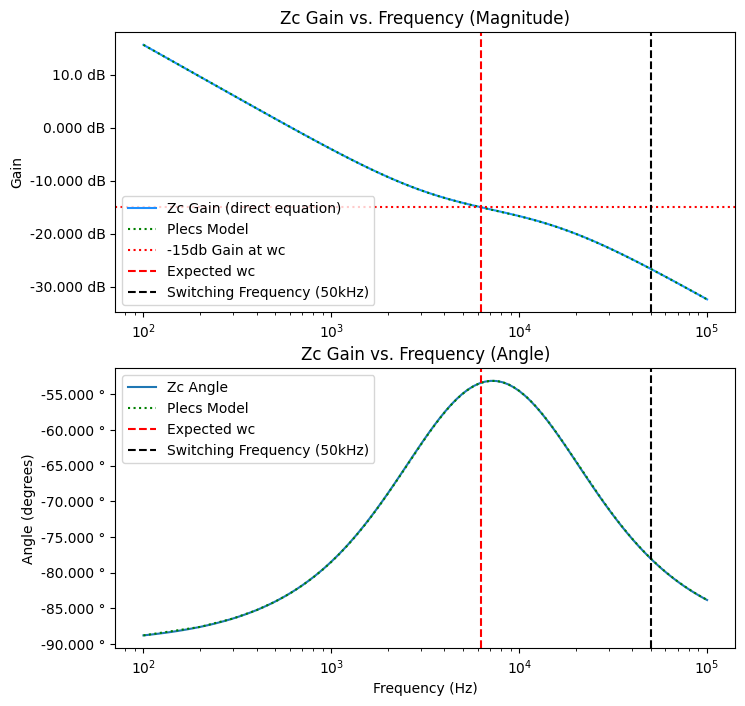

In [138]:
df_compensator = pd.read_csv("plecs_data/compensator_bode.csv")
df_compensator.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

# chosen values
compensator = Compensator(5.6 * 1e3)
Rf1 = compensator.Rf1.to(units.ohm).magnitude
Rc1 = compensator.Rc1.to(units.ohm).magnitude
Cc1 = compensator.Cc1.to(units.farad).magnitude
Cc2 = compensator.Cc2.to(units.farad).magnitude
expected_wc = 1 / (Rc1 * np.sqrt(Cc1 * Cc2)) / 2 / np.pi # to get it into Hz
print(f"Lead element center voltage (ω_c): {si_format(expected_wc, precision = 2)}Hz")

w = np.logspace(2, 5, 100) # * units.hertz
def get_Zc(my_w):
    my_Zc = 1 / (1 / (Rc1 + 1 / (2 * np.pi * 1j * my_w * Cc1)) + 1 / (1 / (2 * np.pi * 1j * my_w * Cc2))) / Rf1 # kOhm
    return my_Zc
Zc = get_Zc(w) # direct equation

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Zc Gain vs. Frequency (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(Zc), linestyle = "solid", color = "dodgerblue", label = "Zc Gain (direct equation)")
ax1.semilogx(df_compensator["w"], df_compensator["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axhline(y = -15, linestyle = "dotted", color = "red", label = "-15db Gain at wc")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Zc Gain vs. Frequency (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(Zc, deg = True), linestyle = "solid", label = "Zc Angle")
ax2.semilogx(df_compensator["w"], df_compensator["CH2"] + 180, linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")

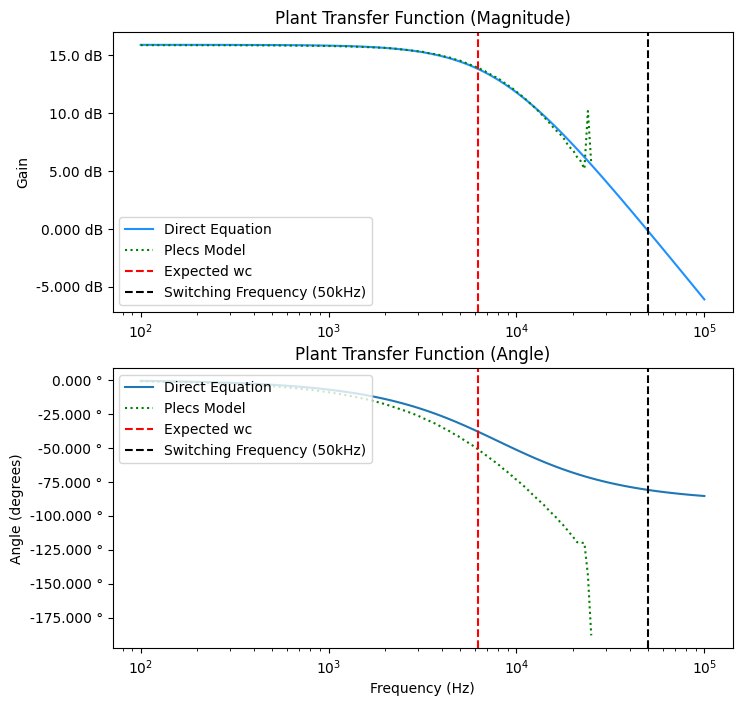

In [139]:
df_plant = pd.read_csv("plecs_data/plant_bode.csv")
df_plant.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

R_Iout_shunt = 5e-3 # * units.ohm
Rload = 0.1 # * units.ohm
Cload = 200e-6 # * units.farad
mystery_factor = 50 # for a total of * 62.5 = 5^4 / 10 = 5^3 / 2
theoretical_plant_bode = Rload / (1 + (2 * np.pi * 1j * w) * Rload * Cload) / Rload * R_Iout_shunt * 25 * mystery_factor

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Plant Transfer Function (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(theoretical_plant_bode), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax1.semilogx(df_plant["w"], df_plant["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Plant Transfer Function (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(theoretical_plant_bode, deg = True), linestyle = "solid", label = "Direct Equation")
ax2.semilogx(df_plant["w"], df_plant["CH2"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")

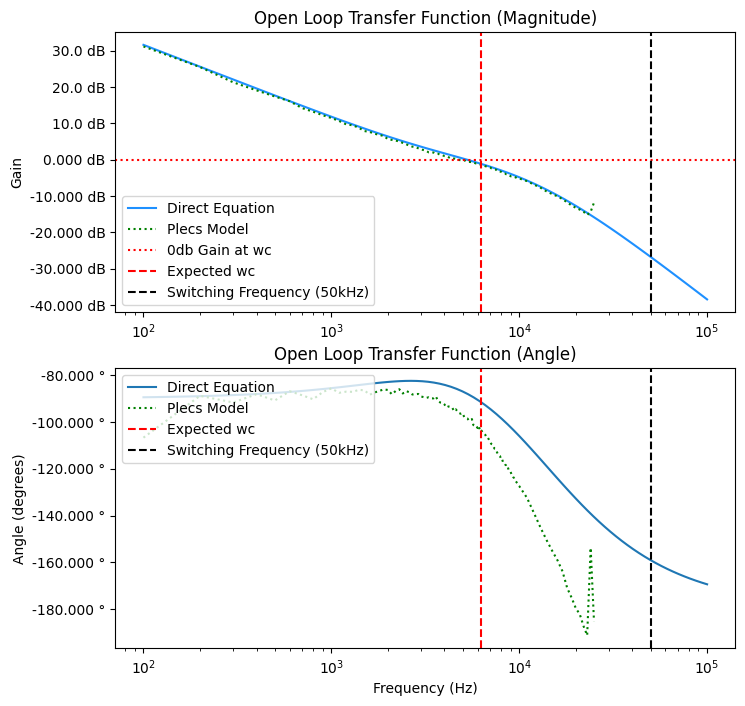

In [140]:
df_open_loop = pd.read_csv("plecs_data/open_loop_bode.csv")
df_open_loop.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

theoretical_open_loop = theoretical_plant_bode * Zc

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Open Loop Transfer Function (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(theoretical_open_loop), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax1.semilogx(df_open_loop["w"], df_open_loop["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axhline(y = 0, linestyle = "dotted", color = "red", label = "0db Gain at wc")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Open Loop Transfer Function (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(theoretical_open_loop, deg = True), linestyle = "solid", label = "Direct Equation")
ax2.semilogx(df_open_loop["w"], df_open_loop["CH2"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")

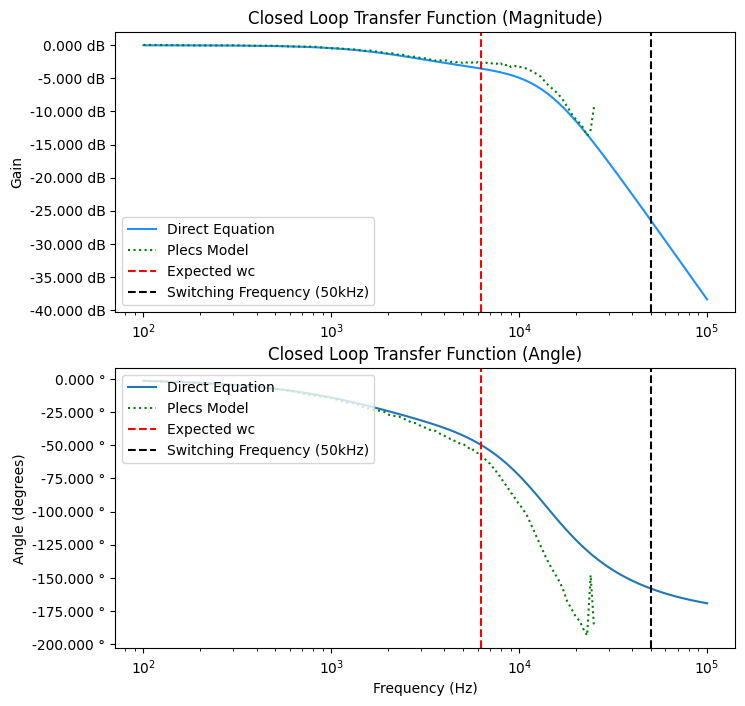

In [141]:
df_closed_loop = pd.read_csv("plecs_data/closed_loop_bode.csv")
df_closed_loop.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

theoretical_closed_loop = theoretical_open_loop / (1 + theoretical_open_loop)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Closed Loop Transfer Function (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(theoretical_closed_loop), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax1.semilogx(df_closed_loop["w"], df_closed_loop["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Closed Loop Transfer Function (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(theoretical_closed_loop, deg = True), linestyle = "solid", label = "Direct Equation")
ax2.semilogx(df_closed_loop["w"], df_closed_loop["CH2"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")

### Boooo

In [142]:
a = 1 * units.meter
b = 2 * units.centimeter

print(a.magnitude)
print(b.magnitude)

print(b.magnitude > a.magnitude)

1
2
True
